In [5]:
!pip install pytorch-metric-learning
#!pip install facenet_pytorch
!pip install ellzaf_ml
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import transforms as tfs
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
from pytorch_metric_learning.losses import ArcFaceLoss
#from pytorch_metric_learning.miners import TripletMarginMiner, BatchHardMiner, MultiSimilarityMiner
#from pytorch_metric_learning import regularizers
#from pytorch_metric_learning.distances import LpDistance, CosineSimilarity
#from facenet_pytorch import fixed_image_standardization
import os
import matplotlib.pyplot as plt
import torch
from ellzaf_ml.models import GhostFaceNetsV2
import numpy as np
np.bool = np.bool_
import torch
from functools import partial
from torch import distributed
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder
import os
from tqdm import tqdm_notebook as tqdm
from torch.nn.functional import cosine_similarity
import torch.nn.functional as F
#from pytorch_metric_learning.samplers import MPerClassSampler
from torch.utils.data import WeightedRandomSampler
import time
from torch.utils.data.dataset import random_split

In [6]:
import random
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed(42)

Random seed set as 42


In [ ]:
class CasiaSampler:
    def __init__(self, data):
        self.targets = data.targets
        self.labels = data.classes
        self.weights = self.compute_weights(self.targets)
        
    def compute_weights(self, targets):
        class_sample_count = np.array([len(np.where(targets == t)[0]) for t in np.unique(targets)])
        weight = 1. / class_sample_count
        samples_weight = np.array([weight[t] for t in targets])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        return samples_weight
        
    def get_sampler(self):
        weights = self.weights
        return WeightedRandomSampler(weights, len(weights))
        

In [ ]:
def compute_weights(targets):
        class_sample_count = np.array([len(np.where(targets == t)[0]) for t in np.unique(targets)])
        weight = 1. / class_sample_count
        samples_weight = np.array([weight[t] for t in targets])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        return samples_weight

In [4]:
import time

train_root = '/kaggle/input/ms1m-retinaface/ms1m-retinaface-t1/imgs'
test_root = '/kaggle/input/lfw-aligned/kaggle/working/lfw-aligned'

transforms_train = tfs.Compose(
            [tfs.ToTensor(),
             tfs.RandomHorizontalFlip(),
             tfs.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])

transforms_test = tfs.Compose(
            [tfs.ToTensor(),
             tfs.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])

train_data = ImageFolder(train_root, transform=transforms_train)
test_data = ImageFolder(test_root, transform=transforms_test)
batch_size = 512

trainloader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=4,
                         drop_last=True)
testloader = DataLoader(test_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=4,
                        drop_last=True)

In [53]:
batch_size = 512

trainloader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=4,
                         drop_last=True)

In [7]:
class BaseDataset(Dataset):
    def __init__(self, data_path, pairs_list, root_dir):
        super().__init__()
        self.data_path = data_path
        self.pairs_list = pairs_list
        self.transform = tfs.Compose([
            tfs.ToTensor(),
            tfs.Resize((112, 112)),
            tfs.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.pairs_list)
    
    def __getitem__(self, idx):
        img_name1, img_name2, issame = self.pairs_list.iloc[idx]
        img1 = Image.open(os.path.join(self.root_dir, img_name1))
        img2 = Image.open(os.path.join(self.root_dir, img_name2))
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        return img1, img2, int(issame)

In [44]:
class Evaluate:
    def __init__(self, data_path, pairs_path, root_dir, size):
        """
        data_path: {str} path to the image folder.
        pairs_path: {str} path to the pairs list.
        size: {int} number related to set size:
                        {
                        0: 25% dataset size
                        1: 50% dataset size
                        2: 75% dataset size
                        3: 100% dataset size
                        None: equals to 3 (100% size)
                        }
        """
        self.root_dir = r'/kaggle/input/lwf-eval/lfw/lfw'
        self.data_path = data_path
        self.pairs_path = pairs_path
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        available_sizes = [None, 0, 1, 2, 3]
        if size == None:
            size = 3
        self.size = size
        self.dataset = self.get_dataset(self.data_path,
                                        self.pairs_path,
                                        self.size)
        self.dataloader = self.get_dataloader(self.dataset)
        self.verbose = 1
        
    def get_dataset(self, data_path, pairs_path, size):
        pairs = pd.read_csv(pairs_path, sep=' ', names=['First_image', 'Second_image', 'Issame'])
        data = BaseDataset(data_path, pairs, self.root_dir)
        return data
    
    def get_dataloader(self, data, batch_size=32):
        dataloader = DataLoader(data, batch_size=32, pin_memory=True, num_workers=0, drop_last=True)
        return dataloader
    
    def compute_threshold(self, model, fpr=0.25):
        id_rate = IdRate()
        metric, threshold = id_rate.id_rate(model, fpr)
        print(f'TPR@FPR={fpr}: {metric}')
        return threshold
    
    def accuracy(self, model, size, metrics):
        
        """
        threshold: {float} computed with TPR@FPR=0.05 metric.
        size: {int} dissipate in quarters.
        metric: {str} any of {"accuracy", "f1-score", "precision", "recall"}
        """
        threshold = self.compute_threshold(model, 0.02)
        batch_res = {'tp': 0,
                     'tn': 0,
                     'fp': 0,
                     'fn': 0}
        for img1, img2, issame in self.dataloader:
            with torch.inference_mode():
                model.eval()
                img1, img2 = img1.to(self.device), img2.to(self.device)
                embd1 = F.normalize(model(img1))
                embd2 = F.normalize(model(img2))
                cos_dist = 1 - cosine_similarity(embd1, embd2, dim=1)
                labels = torch.tensor([1 if cos_dist[idx] <= threshold else -1 for idx in range(32)])
                tp = sum([1 if issame[idx] == labels[idx] == 1 else 0 for idx in range(32)])
                tn = sum([1 if issame[idx] == labels[idx] == -1 else 0 for idx in range(32)])
                fn = sum([1 if issame[idx] == 1 and labels[idx] == -1 else 0 for idx in range(32)])
                fp = sum([1 if issame[idx] == -1 and labels[idx] == 1 else 0 for idx in range(32)])
                batch_res['tp'] += tp
                batch_res['fp'] += fp
                batch_res['tn'] += tn
                batch_res['fn'] += fn
        results = {}
        for metric in metrics:
            if metric not in results.keys():
                results[metric] = 0
            if metric == 'accuracy':
                results['accuracy'] = (batch_res['tp'] + batch_res['tn']) / (batch_res['tp'] + batch_res['tn'] + batch_res['fn'] + batch_res['fp'])
            if metric == 'precision':
                if (batch_res['tp'] + batch_res['fp']) == 0:
                    results['precision'] = 0
                else:
                    results['precision'] = batch_res['tp'] / (batch_res['tp'] + batch_res['fp'])
            if metric == 'recall':
                if (batch_res['tp'] + batch_res['fn']) == 0:
                    results['recall'] = 0
                else:
                    results['recall'] = batch_res['tp'] / (batch_res['tp'] + batch_res['fn'])
            if metric == 'f1_score':
                precision = batch_res['tp'] / (batch_res['tp'] + batch_res['fp'])
                recall = batch_res['tp'] / (batch_res['tp'] + batch_res['fn'])
                if precision + recall == 0:
                    results['f1_score'] = 0
                else:
                    results['f1_score'] = (2 * precision * recall) / (precision + recall)
        if self.verbose == 1:
            print(f"Results: {' | '.join(f'{k}: {v}' for k, v in results.items())}\nTreshold: {np.round(threshold, decimals=5)}")
        return results['accuracy']
                        

In [45]:
class IdRate:
    def __init__(self, annot_path=None, distractor_path=None):
        if annot_path == None:
            self.annot_path = '/kaggle/input/celeba-id/kaggle/working/query_anno.txt'
        else:
            self.annot_path = annot_path
        self.distractors_path = r'/kaggle/input/celeba-id/kaggle/working/distractors_' if distractor_path == None else distractor_path
        self.distractors_img_names = self.get_distractors_names(self.distractors_path)
        self.query_img_names = self.get_query_igm_names(self.annot_path)
    
    def get_query_igm_names(self, annot_path):
        with open(annot_path, 'r') as f:
            query_lines = f.readlines()[1:]
            query_lines = [x.strip().split(',') for x in query_lines]
            query_img_names = [x[0] for x in query_lines]
            return query_img_names
        
    def get_query_dict(self, annot_path):
        with open(annot_path, 'r') as f:
            query_lines = f.readlines()[1:]
            query_lines = [x.strip().split(',') for x in query_lines]
            query_img_names = [x[0] for x in query_lines]
            query_dict = defaultdict(list)
            for img_name, img_class in query_lines:
                query_dict[img_class].append(img_name)
            return query_dict
        
    def get_distractors_names(self, path):
        return os.listdir(path)
    
    def preprocess_image(self, img_path):
        img = Image.open(img_path)
        transform = tfs.Compose([
            tfs.ToTensor(),
            tfs.Resize((112, 112)),
            tfs.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        img = transform(img)
        return img
    
    def compute_embeddings(self, model, images_list, root_dir, normal=True):
        '''
        compute embeddings from the trained model for list of images.
        params:
          model: trained nn model that takes images and outputs embeddings
          images_list: list of images paths to compute embeddings for
        output:
          list: list of model embeddings. Each embedding corresponds to images
                names from images_list
        '''
        embds = []
        with torch.inference_mode():
            for img_path in images_list:
                model.eval()
                img_path_r = os.path.join(root_dir, img_path)
                img = self.preprocess_image(img_path_r).to(device)
                if normal:
                    embd = F.normalize(model(img.unsqueeze(0))).to('cpu')
                else:
                    embd = model(img.unsqueeze(0)).to('cpu')
                embds.append((embd, img_path))
        return embds
    
    def compute_cosine_query_pos(self, query_dict, query_embeddings):
        '''
        compute cosine similarities between positive pairs from query (stage 1)
        params:
          query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                      the dataset. Value: images corresponding to that class
          query_img_names: list of images names
          query_embeddings: list of embeddings corresponding to query_img_names
        output:
          list of floats: similarities between embeddings corresponding
                          to the same people from query list
        '''
        grouped_embds = [[0] for x in range(len(query_dict.values()))]
        embd_names = [x[1] for x in query_embeddings]
        cos_list = []
        embds = [x[0] for x in query_embeddings]
        for idx, values in enumerate(query_dict.values()):
            for value in values:
                if value in embd_names:
                    if type(grouped_embds[idx][0]) != torch.Tensor:
                        grouped_embds[idx] = [query_embeddings[embd_names.index(value)][0]]
                    else:
                        grouped_embds[idx].append(query_embeddings[embd_names.index(value)][0])
        grouped_embds = [x for x in grouped_embds if len(x) > 1]
        for group in grouped_embds:
            embed = group[0]
            for embedding in group[1:]:
                cos_list.append(1 - cosine_similarity(embed, embedding))
        return cos_list


    def compute_cosine_query_neg(self, query_dict, query_embeddings):
        '''
        compute cosine similarities between negative pairs from query (stage 2)
        params:
          query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                      the dataset. Value: images corresponding to that class
          query_img_names: list of images names
          query_embeddings: list of embeddings corresponding to query_img_names
        output:
          list of floats: similarities between embeddings corresponding
                          to different people from query list
        '''
        grouped_embds = [[0] for x in range(len(query_dict.values()))]
        embd_names = [x[1] for x in query_embeddings]
        cos_list = []
        embds = [x[0] for x in query_embeddings]
        for idx, values in enumerate(query_dict.values()):
            for value in values:
                if value in embd_names:
                    if type(grouped_embds[idx][0]) != torch.Tensor:
                        grouped_embds[idx] = [query_embeddings[embd_names.index(value)][0]]
                    else:
                        grouped_embds[idx].append(query_embeddings[embd_names.index(value)][0])
        grouped_embds = [x for x in grouped_embds if len(x) > 1]
        tensor_embds = torch.stack(embds)
        for group in grouped_embds:
            for embedding in group:
                mask = torch.any(tensor_embds != embedding, dim=-1)
                embds_ = tensor_embds[mask]
                cos_list.append(1 - cosine_similarity(embedding.to(device), embds_.to(device)).to('cpu'))
        return torch.cat(cos_list)


    def compute_cosine_query_distractors(self, query_embeddings, distractors_embeddings):
        '''
        compute cosine similarities between negative pairs from query and distractors
        (stage 3)
        params:
          query_embeddings: list of embeddings corresponding to query_img_names
          distractors_embeddings: list of embeddings corresponding to distractors_img_names
        output:
          list of floats: similarities between pairs of people (q, d), where q is
                          embedding corresponding to photo from query, d —
                          embedding corresponding to photo from distractors
        '''
        cos_list = []
        distractors_embeddings = torch.stack([x[0] for x in distractors_embeddings])
        for q_emb in query_embeddings:
            dist_embds_mask = torch.any(distractors_embeddings != q_emb[0], dim=-1)
            cos_list.append(
                1 - cosine_similarity(q_emb[0].to(device), distractors_embeddings[dist_embds_mask].to(device)).to('cpu'))
        return torch.cat(cos_list)
    
    def compute_ir(self, cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
        '''
        compute identification rate using precomputed cosine similarities between pairs
        at a given fpr
        params:
          cosine_query_pos: cosine similarities between positive pairs from query
          cosine_query_neg: cosine similarities between negative pairs from query
          cosine_query_distractors: cosine similarities between negative pairs
                                    from query and distractors
          fpr: false positive rate at which to compute TPR
        output:
          float: threshold for given fpr
          float: TPR at given FPR
        '''
        # Combine negative pairs from query and distractors
        all_neg_cos = torch.cat([torch.tensor(cosine_query_distractors), torch.tensor(cosine_query_neg)])

        # Find the threshold efficiently without sorting the entire list
        if isinstance(fpr, list):
            tprs = {}
            thresholds = []
            for fpr_ in fpr:
                threshold_idx = int(fpr_ * len(all_neg_cos))
                threshold, _ = torch.kthvalue(all_neg_cos, threshold_idx)

                # Convert the threshold to a Python float
                threshold = threshold.item()

                # Calculate TPR at the given FPR
                true_positives = sum(1 for x in cosine_query_pos if x < threshold)
                tpr = true_positives / len(cosine_query_pos)
                tprs[fpr_] = tpr
                thresholds.append(threshold)
            return tprs, thresholds

        threshold_idx = int(fpr * len(all_neg_cos))
        threshold, _ = torch.kthvalue(all_neg_cos, threshold_idx)

        # Convert the threshold to a Python float
        threshold = threshold.item()

        # Calculate TPR at the given FPR
        true_positives = sum(1 for x in cosine_query_pos if x < threshold)
        tpr = true_positives / len(cosine_query_pos)

        return tpr, threshold
    
    def id_rate(self, model, fpr):
        q_embeddings = self.compute_embeddings(model, self.query_img_names,
                                          r'/kaggle/input/celeba-id/kaggle/working/celeba_aligned')
        d_embeddings = self.compute_embeddings(model, self.distractors_img_names,
                                          r'/kaggle/input/celeba-id/kaggle/working/distractors_')
        cos_query_pos = self.compute_cosine_query_pos(self.get_query_dict(self.annot_path),
                                                 q_embeddings)
        cos_query_neg = self.compute_cosine_query_neg(self.get_query_dict(self.annot_path),
                                                 q_embeddings)
        cos_query_distractors = self.compute_cosine_query_distractors(q_embeddings, d_embeddings)
        print(sum(cos_query_pos)/len(cos_query_pos))
        print(sum(cos_query_neg)/(len(cos_query_neg) + 1))
        print(f"TPR@FPR=threshold results: {self.compute_ir(cos_query_pos, cos_query_neg, cos_query_distractors, fpr=[0.01, 0.05, 0.1])}")
        return self.compute_ir(cos_query_pos, cos_query_neg, cos_query_distractors, fpr=fpr)

In [10]:
__all__ = ['iresnet18', 'iresnet34', 'iresnet50', 'iresnet100', 'iresnet200']
using_ckpt = False

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class IBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1):
        super(IBasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.bn1 = nn.BatchNorm2d(inplanes, eps=1e-05,)
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.prelu = nn.PReLU(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.downsample = downsample
        self.stride = stride

    def forward_impl(self, x):
        identity = x
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return out        

    def forward(self, x):
        if self.training and using_ckpt:
            return checkpoint(self.forward_impl, x)
        else:
            return self.forward_impl(x)


class IResNet(nn.Module):
    fc_scale = 7 * 7
    def __init__(self,
                 block, layers, dropout=0, num_features=512, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, fp16=False):
        super(IResNet, self).__init__()
        self.extra_gflops = 0.0
        self.fp16 = fp16
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes, eps=1e-05)
        self.prelu = nn.PReLU(self.inplanes)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.bn2 = nn.BatchNorm2d(512 * block.expansion, eps=1e-05,)
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(512 * block.expansion * self.fc_scale, num_features)
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        nn.init.constant_(self.features.weight, 1.0)
        self.features.weight.requires_grad = False

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.1)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, IBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, eps=1e-05, ),
            )
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, self.groups,
                  self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        with torch.cuda.amp.autocast(self.fp16):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.prelu(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.bn2(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
        x = self.fc(x.float() if self.fp16 else x)
        x = self.features(x)
        return x


def _iresnet(arch, block, layers, pretrained, progress, **kwargs):
    model = IResNet(block, layers, **kwargs)
    if pretrained:
        raise ValueError()
    return model


def iresnet18(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet18', IBasicBlock, [2, 2, 2, 2], pretrained,
                    progress, **kwargs)


def iresnet34(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet34', IBasicBlock, [3, 4, 6, 3], pretrained,
                    progress, **kwargs)


def iresnet50(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet50', IBasicBlock, [3, 4, 14, 3], pretrained,
                    progress, **kwargs)

In [59]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [11]:
img_path = '/kaggle/input/lwf-eval/lfw/lfw'
pairs_path = '/kaggle/input/pairs-list/lfw_pair.txt'
root_dir = '/kaggle/input/lwf-eval/lfw/lfw'
metric = Evaluate(img_path, pairs_path, root_dir, 3)

In [60]:
from collections import defaultdict
import os
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GhostFaceNetsV2(image_size=112, num_classes=None, dropout=0., width=1.3).to(device)
loss_f = ArcFaceLoss(num_classes=91391,
                              embedding_size=512,
                              scale=64).to(device)
optimizer = torch.optim.SGD([
                {'params': model.parameters()},
                {'params': loss_f.parameters()}], lr=0.1, weight_decay=5e-04)

In [62]:
def train_loop(epochs, model, loss, optimizer, trainloader):
    
    
    train_results = {'train_loss': [],
                     'validation_loss': [],
                     'accuracy': []}
    for epoch in range(epochs):
        model.train()
        ep_loss = 0
        iters = 0
        for img_batch, label_batch in trainloader:
            iters += 1
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            embeddings = model(img_batch)
            train_loss = loss(embeddings, label_batch)
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            ep_loss += train_loss.item()
            optimizer.zero_grad()
            if iters % 20 == 0:
                for g in optimizer.param_groups:
                    if g['lr'] > 1e-5:
                        g['lr'] = g['lr'] * 0.99
                        print(train_loss)
            if iters % 1000 == 0:
                print(f"iter: {iters} | loss: {train_loss}")
        #if epoch in [3, 5, 7, 16, 20, 24]:
        #    print(f"Epoch: {epoch + 1}, lr was reduced")
        #    for g in optimizer.param_groups:
        #        if g['lr'] > 1e-5:
        #            g['lr'] = g['lr'] * 0.1
        
        train_results['train_loss'].append(ep_loss / len(trainloader))
        
        ep_loss = 0
        with torch.inference_mode():
            model.eval()
            accuracy = metric.accuracy(model, 3, ['accuracy', 'recall', 'precision', 'f1_score'])
            train_results['accuracy'].append(accuracy)
        print(f"Epoch: {epoch + 1} | train_loss: {train_results['train_loss'][-1]} | accuracy: {train_results['accuracy'][-1]}")
        
    return train_results

In [ ]:
res = train_loop(35, model, loss_f, optimizer, trainloader)

In [14]:
img_path = '/kaggle/input/lwf-eval/lfw/lfw'
pairs_path = '/kaggle/input/pairs-list/lfw_pair.txt'
root_dir = '/kaggle/input/lwf-eval/lfw/lfw'
metric = Evaluate(img_path, pairs_path, root_dir, 3)
metric.accuracy(model, 3, ['accuracy', 'recall', 'precision', 'f1_score'])

Results: accuracy: 0.9821189839572193 | recall: 0.9746666666666667 | precision: 0.9895093062605753 | f1_score: 0.9820319059613771
Treshold: 0.67582


0.9821189839572193

In [8]:
!pip install onnxruntime-gpu
!pip install insightface
import onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 9.7 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=882816 sha256=b29480a6620d70f108910d71b9ae3b715410eb5d517daa6904edf68f4d4b60da
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface


In [12]:
def issame(img1, img2):
    transform = tfs.Compose([
        tfs.ToTensor(),
        tfs.Resize((112, 112)),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    with torch.inference_mode():
        model.eval()
        print(transform(img1).unsqueeze(0).shape)
        embd1 = model(transform(img1).unsqueeze(0).to(device))
        embd2 = model(transform(img2).unsqueeze(0).to(device))
    print(F.cosine_similarity(embd1, embd2))

In [30]:
from PIL import Image
from torch.nn import functional as F
img1 = Image.open('/kaggle/input/ssssssssssssssssss/.jpg')
img2 = Image.open('/kaggle/input/ssssssssssssssssss/MV5BMTYwNDM0NDA3M15BMl5BanBnXkFtZTcwNTkzMjQ3OA._V1_.jpg')
issame(img1, img2)


torch.Size([1, 3, 112, 112])
tensor([1.0000], device='cuda:0')


In [42]:
device='cuda'
model = GhostFaceNetsV2(image_size=112, num_classes=None).to(device)
model.load_state_dict(torch.load('/kaggle/input/gftest/model.pth'))

<All keys matched successfully>

In [48]:
from collections import defaultdict
img_path = '/kaggle/input/lwf-eval/lfw/lfw'
pairs_path = '/kaggle/input/pairs-list/lfw_pair.txt'
root_dir = '/kaggle/input/lwf-eval/lfw/lfw'
metric = Evaluate(img_path, pairs_path, root_dir, 3)
metric.accuracy(model, 3, ['accuracy', 'recall', 'precision', 'f1_score'])

tensor([0.4827])
tensor(0.9755)


/tmp/ipykernel_34/52080936.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_neg_cos = torch.cat([torch.tensor(cosine_query_distractors), torch.tensor(cosine_query_neg)])


TPR@FPR=threshold results: ({0.01: 0.8589743589743589, 0.05: 0.9555555555555556, 0.1: 0.9683760683760684}, [0.6797361969947815, 0.8114634156227112, 0.8574811816215515])
TPR@FPR=0.02: 0.9076923076923077
Results: accuracy: 0.9802807486631016 | recall: 0.9753333333333334 | precision: 0.9851851851851852 | f1_score: 0.9802345058626465
Treshold: 0.74512


0.9802807486631016

In [49]:
np.int = int
import insightface
import onnxruntime
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
app = FaceAnalysis(providers=['CUDAExecutionProvider'], allowed_modules=['detection'])
app.prepare(ctx_id=0, det_size=(640, 640))
img1 = ins_get_image('/kaggle/input/ceeba/Liam_Neeson_Deauville_2012', to_rgb=True)
img2 = ins_get_image('/kaggle/input/asaasa/photo_2024-01-22_02-32-58', to_rgb=True)
faces1 = app.get(img1)
faces2 = app.get(img2)
rimg = app.draw_on(img1, faces1)
cv2.imwrite("./t1_output.jpg", rimg)

2024-04-10 02:34:12.513735321 [E:onnxruntime:Default, provider_bridge_ort.cc:1548 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1209 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-04-10 02:34:12.836488690 [E:onnxruntime:Default, provider_bridge_ort.cc:1548 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1209 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-04-10 02:34:12.880517400 [E:onnxruntime:Default, provider_bridge_ort.cc:1548 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0


2024-04-10 02:34:12.953437755 [E:onnxruntime:Default, provider_bridge_ort.cc:1548 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1209 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-04-10 02:34:13.047845662 [E:onnxruntime:Default, provider_bridge_ort.cc:1548 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1209 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)


True

In [50]:
from insightface.utils import face_align

In [52]:
img1 = ins_get_image('/kaggle/input/sdawdawds/MV5BMzJhNGYyMDItN2ZiZS00MDJlLWE2OTUtYTlhODNkMjNmNTYxXkEyXkFqcGdeQXVyMjQwMDg0Ng._V1_', to_rgb=True)
img2 = ins_get_image('/kaggle/input/sdawdawds/images', to_rgb=True)

In [ ]:
import time
s = time.time()
faces1 = app.get(img1)
faces2 = app.get(img2)
img_c1 = face_align.norm_crop(img1, faces1[0]['kps'])
img_c2 = face_align.norm_crop(img2, faces2[0]['kps'])
print(time.time() - s)
issame(img_c1, img_c2)


In [32]:
issame(img_c1, img_c2)

torch.Size([1, 3, 112, 112])
tensor([0.1714], device='cuda:0')


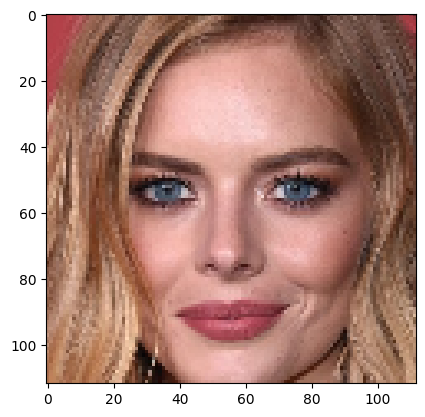

In [54]:
plt.imshow(img_c1)

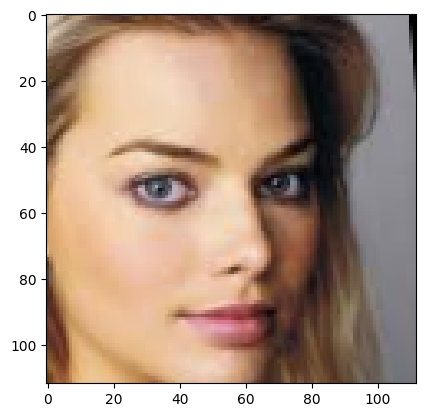

In [55]:
plt.imshow(img_c2)

In [71]:
torch.save(model.state_dict(), 'ghostfacev2_0_5.pth')